# Project 2: Ames housing data to create a regression model that predicts the price of houses in Ames, IA

### Problem Statement

A construction and development company new to the Ames, IA area has recently received permission to begin construction of new residences. The company has asked for insight into which kind of characteristics and amenities a house should have in order for them to create a baseline house that guarantees that their investment is going to be maximized.


### Model developed

The dataset that we are working with has around 2051 observations  and 82 columns from which most of them contain categorical values (nominal or ordinal) that we want to analyze, because of this we want to use a model such as Lasso. This particular model will allow us to find feature importance within our model and allow us to determine which attributes are the ones that contribute the most when it comes to predicting the price of houses. 

Furthermore, it's important for this problem statement to be able to provide another  interpretable model that can give an indication of what numerical features might also contribute for the the prediction of price of houses 

In this model success will be evaluated by the R^2 score provided by the fitted model after performing cross-validation on the training dataset. 


#### Importing Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, Lasso, LogisticRegression
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.ensemble import VotingRegressor

In [2]:
# By contatenating both training and testint dataset we ensure that
# all the feature engineering and preprocesseing is mantained in both
# datasets.  

df_train = pd.read_csv('../datasets/train.csv')
df_test = pd.read_csv('../datasets/test.csv')
df = pd.concat([df_train, df_test], ignore_index=True)
df.head()

,Id,PID,MS SubClass,MS Zoning,Lot Frontage,Lot Area,Street,Alley,Lot Shape,Land Contour,...,Screen Porch,Pool Area,Pool QC,Fence,Misc Feature,Misc Val,Mo Sold,Yr Sold,Sale Type,SalePrice
0,109,533352170,60,RL,NaN,13517,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,130500.0
1,544,531379050,60,RL,43.0,11492,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,4,2009,WD,220000.0
2,153,535304180,20,RL,68.0,7922,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,1,2010,WD,109000.0
3,318,916386060,60,RL,73.0,9802,Pave,NaN,Reg,Lvl,...,0,0,NaN,NaN,NaN,0,4,2010,WD,174000.0
4,255,906425045,50,RL,82.0,14235,Pave,NaN,IR1,Lvl,...,0,0,NaN,NaN,NaN,0,3,2010,WD,138500.0


In [3]:
df_test.shape

(878, 80)

#### Data Cleaning and EDA

In [4]:
df.isna().sum().sort_values()

Id                 0
Sale Type          0
Heating QC         0
Central Air        0
1st Flr SF         0
                ... 
Fireplace Qu    1422
Fence           2357
Alley           2731
Misc Feature    2823
Pool QC         2916
Length: 81, dtype: int64

In [5]:
corr_vals = df.corr()['SalePrice'].sort_values()

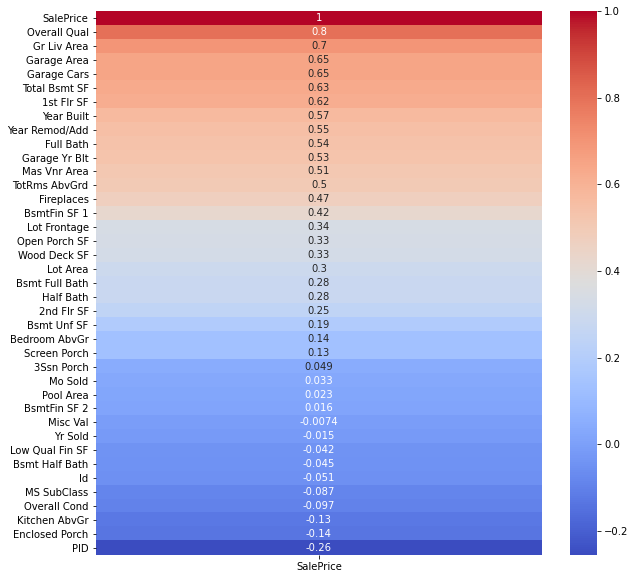

In [6]:
plt.figure(figsize = (10, 10))
corr = df.corr()
corr_sort = corr.sort_values(by = ['SalePrice'], axis = 0, ascending = False)
corr_sort
sns.heatmap(corr_sort[['SalePrice']], annot=True, cmap='coolwarm')
plt.savefig('../images/initial_corr_numerical.png',bbox_inches = 'tight');

In [7]:
# Selecting top 5 Numerical Features with high corr
features_high_corr = ['Overall Qual', 'Gr Liv Area', 'Garage Area', 'Total Bsmt SF', '1st Flr SF', 'SalePrice','Full Bath']
df_first_iter = df[features_high_corr]
df[features_high_corr].dtypes

Overall Qual       int64
Gr Liv Area        int64
Garage Area      float64
Total Bsmt SF    float64
1st Flr SF         int64
SalePrice        float64
Full Bath          int64
dtype: object

In [8]:
df_first_iter.head()

,Overall Qual,Gr Liv Area,Garage Area,Total Bsmt SF,1st Flr SF,SalePrice,Full Bath
0,6,1479,475.0,725.0,725,130500.0,2
1,7,2122,559.0,913.0,913,220000.0,2
2,5,1057,246.0,1057.0,1057,109000.0,1
3,5,1444,400.0,384.0,744,174000.0,2
4,6,1445,484.0,676.0,831,138500.0,2


In [9]:
df_first_iter.describe()

,Overall Qual,Gr Liv Area,Garage Area,Total Bsmt SF,1st Flr SF,SalePrice,Full Bath
count,2929.000000,2929.000000,2928.000000,2928.000000,2929.000000,2051.000000,2929.000000
mean,6.093547,1498.606009,472.679303,1050.901981,1158.882212,181469.701609,1.566064
std,1.409420,502.174926,214.948914,438.999166,390.248168,79258.659352,0.552400
min,1.000000,334.000000,0.000000,0.000000,334.000000,12789.000000,0.000000
25%,5.000000,1126.000000,320.000000,793.000000,876.000000,129825.000000,1.000000
50%,6.000000,1442.000000,480.000000,990.000000,1084.000000,162500.000000,2.000000
75%,7.000000,1742.000000,576.000000,1300.500000,1384.000000,214000.000000,2.000000
max,10.000000,5642.000000,1488.000000,6110.000000,5095.000000,611657.000000,4.000000


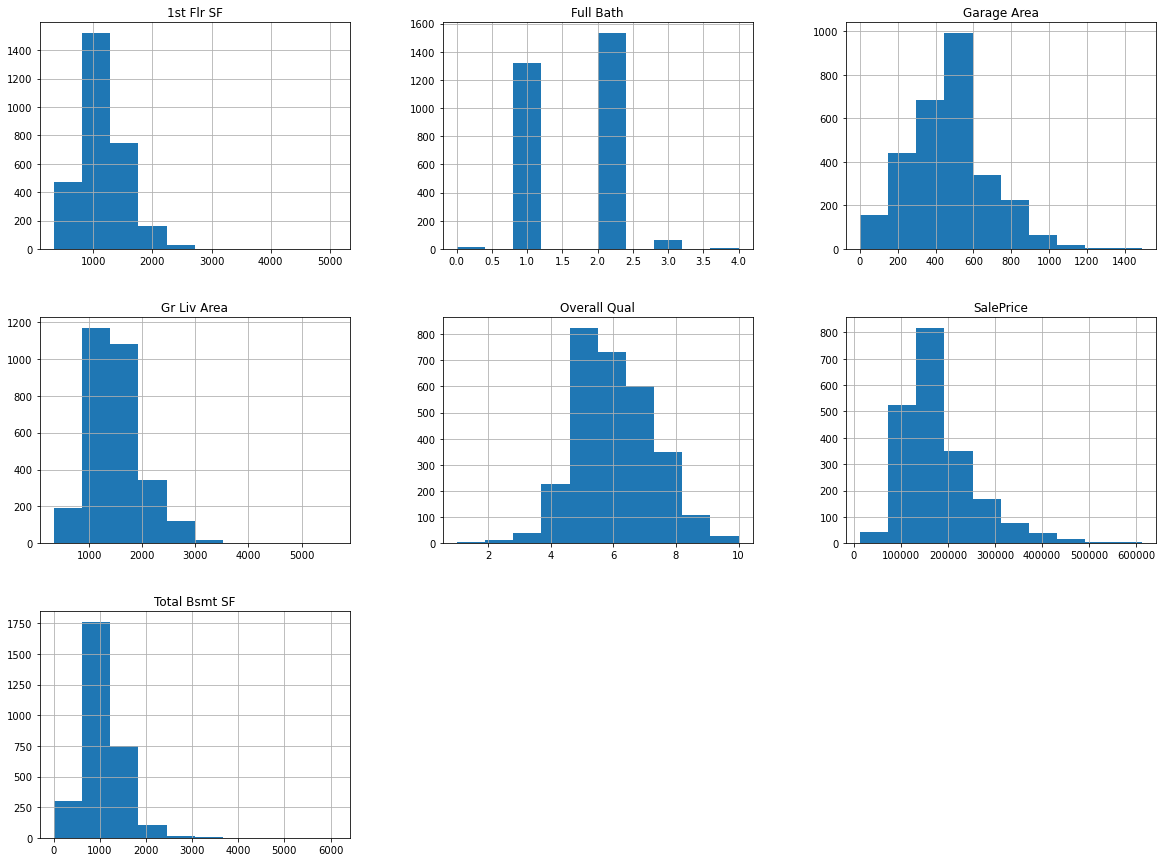

In [10]:
df_first_iter.hist(figsize=(20,15))
plt.savefig('../images/hist_numerical.png',bbox_inches = 'tight');

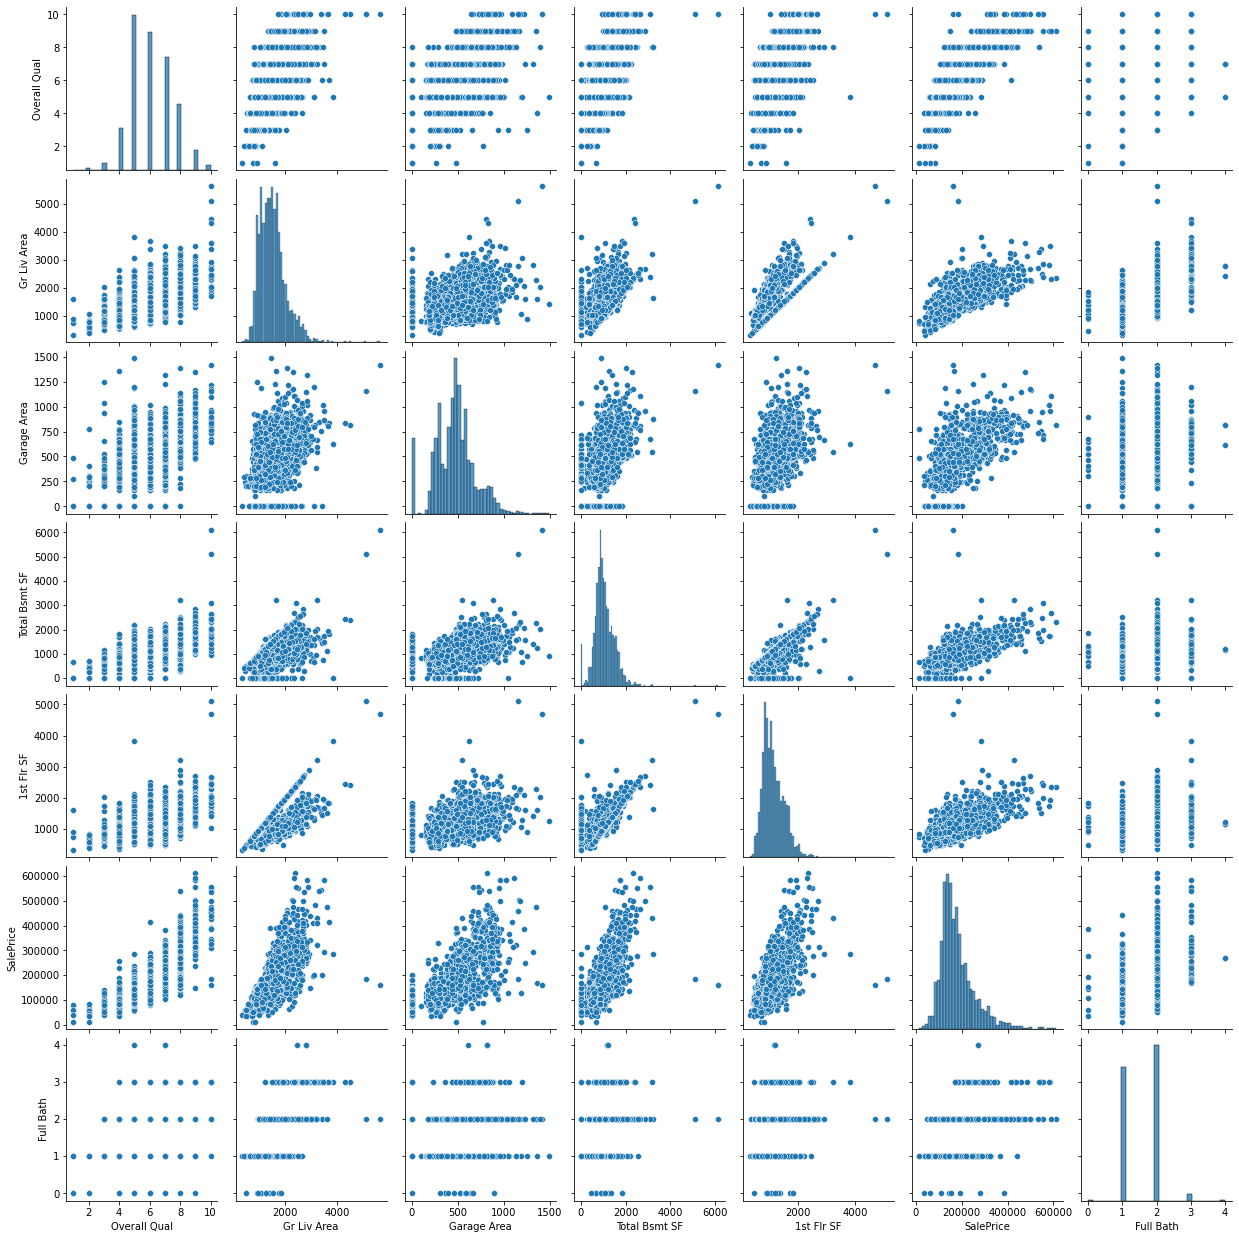

In [11]:
sns.pairplot(df_first_iter)
plt.savefig('../images/pairplot_numerical.png',bbox_inches = 'tight')

In [12]:
df_first_iter.isna().sum()

Overall Qual       0
Gr Liv Area        0
Garage Area        1
Total Bsmt SF      1
1st Flr SF         0
SalePrice        878
Full Bath          0
dtype: int64

In [13]:
df_first_iter.shape

(2929, 7)

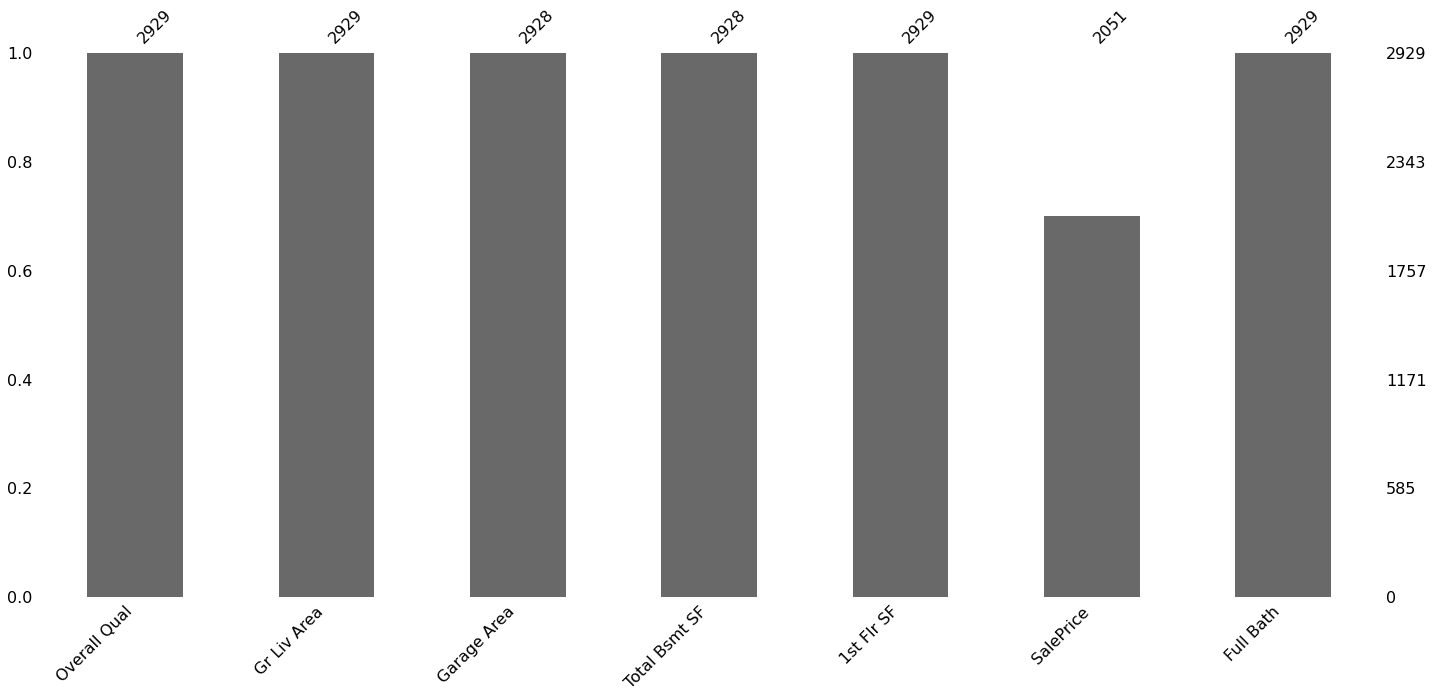

In [14]:
import missingno as msno 
msno.bar(df_first_iter)
plt.savefig('../images/missing_vals.png', bbox_inches = 'tight');

In [15]:
# Adressing missing values; decided to drop nans due to the small  
# presece of them in the data 
df_first_iter = df_first_iter.dropna(subset=['Garage Area', 'Total Bsmt SF'])

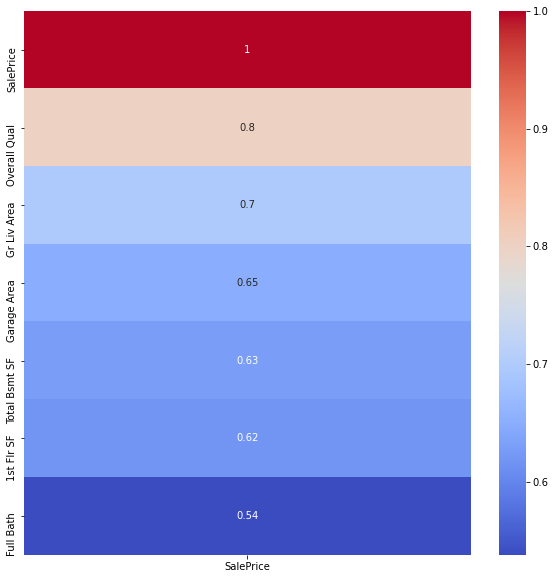

In [16]:
plt.figure(figsize = (10, 10))
corr = df_first_iter.corr()
corr_sort = corr.sort_values(by = ['SalePrice'], axis = 0, ascending = False)
corr_sort
sns.heatmap(corr_sort[['SalePrice']], annot=True, cmap='coolwarm')
plt.savefig('../images/closer_corr_numerical.png', bbox_inches = 'tight');

### Model using numerical features for prediction of `SalesPrice`

#### Define feature Matrix and Target

In [17]:
proc_train = df_first_iter.loc[df['SalePrice'].notna()]
proc_test = df_first_iter.loc[df['SalePrice'].isna()]

In [18]:
X = proc_train.drop(columns=['SalePrice'])
y = proc_train['SalePrice']

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, random_state = 42, test_size=.3)


#### Instantiate, Fit and Model for numerical features

In [20]:
lr = LinearRegression()
lr.fit(X_train, y_train)
lr_preds = lr.predict(X_train)
rmse_linear = np.sqrt(mean_squared_error(np.array(y_train), lr_preds))

In [21]:
lr.score(X_train, y_train), lr.score(X_test, y_test)

(0.758000544135671, 0.8128217672634088)

In [22]:
r2_lr = lr.score(X_test, y_test)

In [23]:
list_num_features = list(zip(X.columns, lr.coef_))

Interpretation of Coefficients:
Now as we consider multiple features, our interpreatation are holding all other variables constant. 
- For every 1 unit increase in `1st Flr SF`, we expect `SalePrice`  to increase by 13.921302344970547, holding all else constant
- For every 1 unit increase in `Full Bath`, we expect `SalePrice`  to increase by 4500.09606563663, holding all else constant
- For every 1 unit increase in `Garage Area`, we expect `SalePrice`  to increase by 58.83531628845373, holding all else constant
- For every 1 unit increase in `Gr Liv Area`, we expect `SalePrice`  to increase by 39.13412475280334, holding all else constant
- For every 1 unit increase in `Overall Qual`, we expect `SalePrice`  to increase by 25276.80036221399, holding all else constant
- For every 1 unit increase in `Total Bsmt SF`, we expect `SalePrice`  to increase by 14.699568507929111, holding all else constant

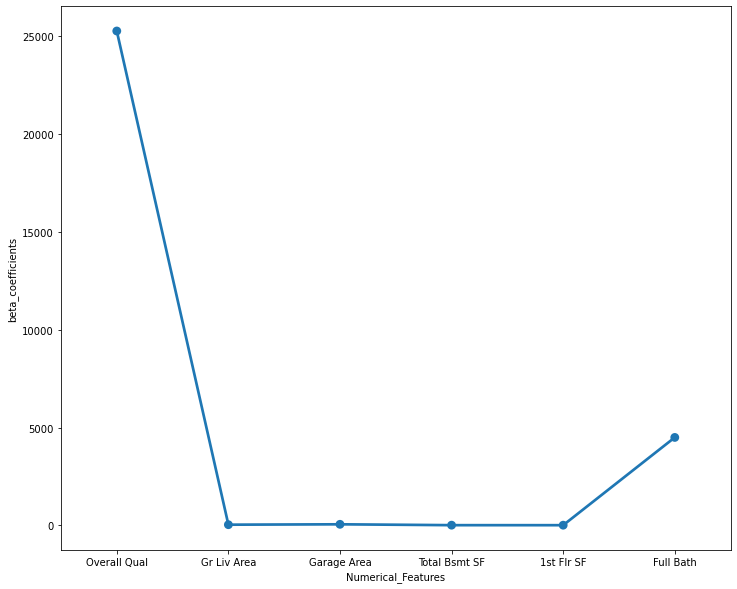

In [24]:
df_temp = pd.DataFrame(list_num_features, columns =['Numerical_Features', 'beta_coefficients'])
plt.figure(figsize=(12,10))
ax = sns.pointplot(x="Numerical_Features", y="beta_coefficients",data=df_temp)
plt.savefig('../images/betas_graph_numerical.png', bbox_inches = 'tight');

### Model using numerical features for prediction of `SalesPrice` w/ PolyFeatures

In [25]:
proc_train = df_first_iter.loc[df['SalePrice'].notna()]
proc_test = df_first_iter.loc[df['SalePrice'].isna()]

In [26]:
X = proc_train.drop(columns=['SalePrice'])
y = proc_train['SalePrice']

poly = PolynomialFeatures(include_bias=False)
X_poly = poly.fit_transform(X)

In [27]:
lr_poly = Pipeline([
    ('poly', PolynomialFeatures(include_bias=False)),
    ('lr_p', LinearRegression())
])

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, random_state = 42, test_size=.3)


In [29]:
#lr_poly = LinearRegression()
lr_poly.fit(X_train, y_train)
lr_preds_poly = lr_poly.predict(X_test)
rmse_linear_poly = np.sqrt(mean_squared_error(np.array(y_test), lr_preds_poly))

In [30]:
lr_poly.score(X_train, y_train), lr_poly.score(X_test, y_test)

(0.8623040438544416, 0.8700362356365726)

In [31]:
r2_lrReg_poly = lr_poly.score(X_test, y_test)

In [32]:
lr_poly.named_steps['lr_p'].coef_

array([-7.31915824e+03, -2.07275285e+00, -1.80767457e+01, -1.74408064e+01,
        2.29844001e+01, -2.92721411e+04, -1.39129587e+03,  1.48750814e+01,
        1.25375994e+01,  1.82302538e+01,  4.42642041e+00, -4.23634874e+03,
       -1.33708222e-02,  2.50857983e-02,  2.87851959e-02, -7.53316365e-02,
        3.07011974e+01, -3.58506203e-02, -4.16921534e-03,  1.19318027e-02,
       -1.70390713e+01, -1.23218725e-02, -5.79796510e-02, -1.75052518e-02,
        5.61781218e-02, -3.65428676e+00,  6.65256128e+03])

### Model using categorical features for prediction `Sales`

In [33]:
# Obtaining the features that are categorical and that
# don't contain NaNs
temp_set = None
categorical_features = []
for i in df.columns:
    add_col = True
    if df[i].dtypes == 'object':
        temp_set = set(df[i])
        for x in temp_set:
            if x != x:
                add_col = False
                break
        if add_col:
            categorical_features.append(i)

categorical_features.append('SalePrice')

In [34]:
# Creating dummy columns
def dummies_list_df(list_cols, df):
    for i in list_cols:
        pd.get_dummies(df, columns=[i], prefix=i, inplace=True)

In [35]:
df_sec_mod = df[categorical_features]
categorical_features.remove('SalePrice')
df_sec_iter = df_sec_mod.drop(columns='SalePrice')
df_sec_iter.dtypes

MS Zoning       object
Street          object
Lot Shape       object
Land Contour    object
Utilities       object
Lot Config      object
Land Slope      object
Neighborhood    object
Condition 1     object
Condition 2     object
Bldg Type       object
House Style     object
Roof Style      object
Roof Matl       object
Exterior 1st    object
Exterior 2nd    object
Exter Qual      object
Exter Cond      object
Foundation      object
Heating         object
Heating QC      object
Central Air     object
Kitchen Qual    object
Functional      object
Paved Drive     object
Sale Type       object
dtype: object

In [36]:
df_sec_iter = pd.get_dummies(df_sec_mod, columns=categorical_features)
df_keeper_df = df_sec_iter.copy()

In [37]:
df_sec_iter.isna().sum().sort_values()

Roof Matl_ClyTile         0
Exterior 2nd_BrkFace      0
Exterior 2nd_CBlock       0
Exterior 2nd_CmentBd      0
Exterior 2nd_HdBoard      0
                       ... 
Condition 1_RRNn          0
Condition 2_Artery        0
Condition 2_Feedr         0
Condition 1_Feedr         0
SalePrice               878
Length: 188, dtype: int64

In [38]:
proc_train = df_sec_iter.loc[df['SalePrice'].notna()]
proc_test = df_sec_iter.loc[df['SalePrice'].isna()]

In [39]:
X = proc_train.drop(columns=['SalePrice'])
y = proc_train['SalePrice']

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, random_state = 42, test_size=.3)


#### Instantiate, Fit and Model for categorical features

In [41]:
pipe = Pipeline([
    ('ss', StandardScaler()),
    ('lasso', LassoCV())
])

In [42]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('ss', StandardScaler()), ('lasso', LassoCV())])

In [43]:
lasso_pred = pipe.predict(X_test)
rmse_lasso =  np.sqrt(mean_squared_error(np.array(y_test), lasso_pred))

In [44]:
pipe.score(X_train, y_train), pipe.score(X_test, y_test)

(0.8157740934052999, 0.7469082689037871)

In [45]:
r2_lasso = pipe.score(X_test, y_test)

In [46]:
coeff_values = set(zip(X.columns, pipe.named_steps['lasso'].coef_))
coeff_values

{('Bldg Type_1Fam', 0.0),
 ('Bldg Type_2fmCon', 0.0),
 ('Bldg Type_Duplex', 0.0),
 ('Bldg Type_Twnhs', -7814.482672538884),
 ('Bldg Type_TwnhsE', -11492.533270746986),
 ('Central Air_N', -3888.7108779282466),
 ('Central Air_Y', 3.7966808790944594e-11),
 ('Condition 1_Artery', -0.0),
 ('Condition 1_Feedr', -403.7670800616665),
 ('Condition 1_Norm', 525.3397305688786),
 ('Condition 1_PosA', 1843.9904243903243),
 ('Condition 1_PosN', 3124.8470390360194),
 ('Condition 1_RRAe', -1857.4063168842933),
 ('Condition 1_RRAn', -0.0),
 ('Condition 1_RRNe', -211.63660750131953),
 ('Condition 1_RRNn', -0.0),
 ('Condition 2_Artery', -822.4167889912522),
 ('Condition 2_Feedr', -769.1885343185346),
 ('Condition 2_Norm', 0.0),
 ('Condition 2_PosA', 143.40649564543088),
 ('Condition 2_PosN', 191.51410364451024),
 ('Condition 2_RRAe', 0.0),
 ('Condition 2_RRAn', -86.94285136293732),
 ('Condition 2_RRNn', -4.093595954863266),
 ('Exter Cond_Ex', 0.0),
 ('Exter Cond_Fa', 0.0),
 ('Exter Cond_Gd', 1013.8885731

In [47]:
# Selecting the model features
# Reference form the following URL: https://scikit-learn.org/stable/auto_examples/feature_selection/plot_select_from_model_diabetes.html#sphx-glr-auto-examples-feature-selection-plot-select-from-model-diabetes-py
importance = np.abs(pipe.named_steps['lasso'].coef_)

In [48]:
# As referenced in the URL, " Only the features with the coef_ higher than the threshold will remain. 
# Here, we want to set the threshold slightly above the third highest 
# coef_ calculated by LassoCV() from our data."
# In my case im selecting the top 10 features 

idx_third = importance.argsort()[-3]
threshold = importance[idx_third] + 0.01

idx_features = (-importance).argsort()[:10]
name_features = np.array(X.columns)[idx_features]
print('Selected features: {}'.format(name_features))

for i in name_features:
    print(i)

Selected features: ['Neighborhood_NridgHt' 'Neighborhood_NoRidge' 'Kitchen Qual_Ex'
 'Neighborhood_StoneBr' 'Exter Qual_Ex' 'Exter Qual_TA' 'Bldg Type_TwnhsE'
 'Bldg Type_Twnhs' 'Kitchen Qual_TA' 'Foundation_PConc']
Neighborhood_NridgHt
Neighborhood_NoRidge
Kitchen Qual_Ex
Neighborhood_StoneBr
Exter Qual_Ex
Exter Qual_TA
Bldg Type_TwnhsE
Bldg Type_Twnhs
Kitchen Qual_TA
Foundation_PConc


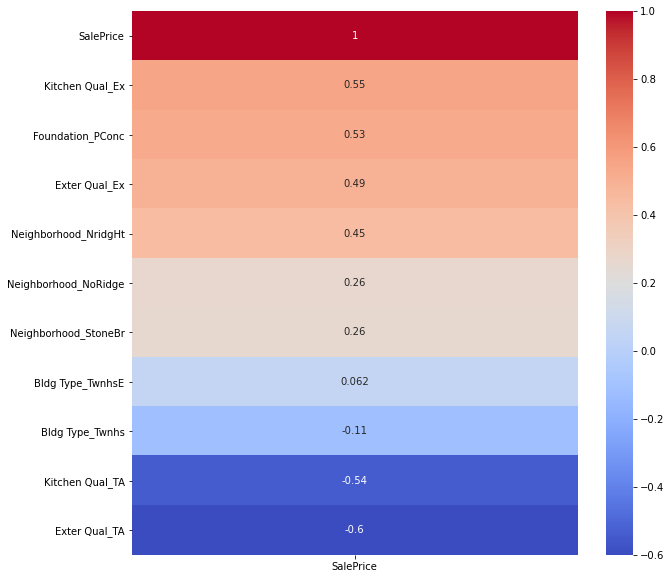

In [49]:
tt_list = list(name_features)
tt_list.append('SalePrice')

temp_dtt = df_keeper_df[tt_list]

plt.figure(figsize = (10, 10))
corr = temp_dtt.corr()
corr_sort = corr.sort_values(by = ['SalePrice'], axis = 0, ascending = False)
corr_sort
sns.heatmap(corr_sort[['SalePrice']], annot=True, cmap='coolwarm')
plt.savefig('../images/corr_categorical.png',bbox_inches = 'tight');

In [50]:
sel_features_coef = []
for i in coeff_values:
    if i[0] in list(name_features):
        sel_features_coef.append((i))

In [51]:
sel_features_coef

[('Neighborhood_NoRidge', 13528.65353119346),
 ('Kitchen Qual_Ex', 12937.043762897161),
 ('Foundation_PConc', 7285.738526517681),
 ('Bldg Type_Twnhs', -7814.482672538884),
 ('Bldg Type_TwnhsE', -11492.533270746986),
 ('Exter Qual_TA', -11791.416274374715),
 ('Exter Qual_Ex', 12251.853879244),
 ('Neighborhood_StoneBr', 12468.928933116822),
 ('Kitchen Qual_TA', -7476.025065072656),
 ('Neighborhood_NridgHt', 16003.431233421887)]

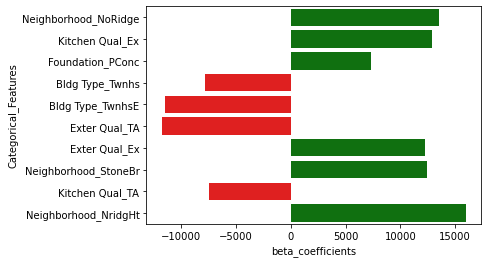

In [52]:
df_temp = pd.DataFrame(sel_features_coef, columns =['Categorical_Features', 'beta_coefficients'])
df_temp['pos'] = df_temp['beta_coefficients'].apply(lambda x: True if x > 0 else False) 
ax = sns.barplot(y="Categorical_Features", x="beta_coefficients", 
                 data=df_temp, orient='h' ,palette=df_temp.pos.map({True: 'g', False: 'r'}))
plt.savefig('../images/barplot_categorical.png',bbox_inches = 'tight');

### Comparison with baseline score

In [53]:
proc_train = df_first_iter.loc[df['SalePrice'].notna()]
proc_test = df_first_iter.loc[df['SalePrice'].isna()]

In [54]:
base = proc_train['SalePrice'].mean()
y = proc_train['SalePrice']
base_pred = np.array([ base for x in range(y.shape[0])])
rmse_base = np.sqrt(mean_squared_error(np.array(y), base_pred))

In [55]:
print(f'Base                            RMSE: {rmse_base}')
print(f'LinearRegresion                 RMSE: {rmse_linear}')
print(f'LinearRegresion w/ PolyFeatures RMSE: {rmse_linear_poly}')
print(f'Lasso                           RMSE: {rmse_lasso}')

Base                            RMSE: 79242.76900782275
LinearRegresion                 RMSE: 38504.49197396322
LinearRegresion w/ PolyFeatures RMSE: 29345.581067731102
Lasso                           RMSE: 38895.20977160721


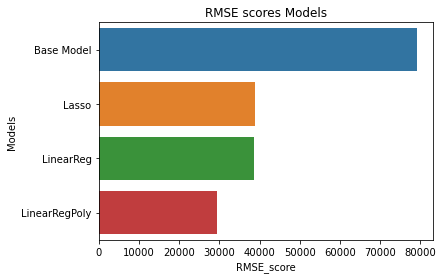

In [56]:
tuples_data = [('Base Model', rmse_base), ('LinearReg', rmse_linear),
               ('LinearRegPoly', rmse_linear_poly), ('Lasso', rmse_lasso)]
df_temp = pd.DataFrame(tuples_data, columns =['Models', 'RMSE_score']).sort_values(by='RMSE_score',ascending=False)
sns.barplot(y='Models', x='RMSE_score', data=df_temp, orient='h')
plt.title('RMSE scores Models')
plt.savefig('../images/rmse_scores.png',bbox_inches = 'tight');

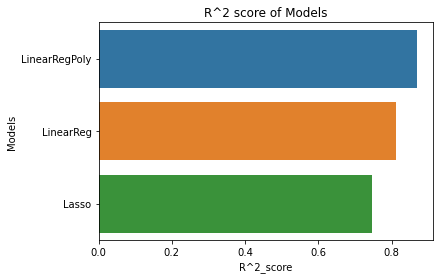

In [57]:
tuples_data_r2 = [('LinearReg', r2_lr),
               ('LinearRegPoly', r2_lrReg_poly), ('Lasso', r2_lasso)]
df_temp = pd.DataFrame(tuples_data_r2, columns =['Models', 'R^2_score']).sort_values(by='R^2_score',ascending=False)
sns.barplot(y='Models', x='R^2_score', data=df_temp, orient='h')
plt.title('R^2 score of Models')
plt.savefig('../images/r2_scores.png',bbox_inches = 'tight');

### Voting Regressor Classifier

In [58]:
# Reference for using voting regressor taken 
# from the following URL:https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingRegressor.html
X = proc_train.drop(columns=['SalePrice'])
y = proc_train['SalePrice']

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, random_state = 42, test_size=.3)

In [60]:
ensamble = VotingRegressor([('lr_2', lr_poly), ('lasso', pipe)])

In [61]:
ensamble.fit(X_train, y_train) #test our model on the test data
r2_score = ensamble.score(X_test, y_test)
preds_ensamble = ensamble.predict(X_test)

In [62]:
rmse_ensamble = np.sqrt(mean_squared_error(np.array(y_test), preds_ensamble))
rmse_ensamble

30758.03720518232

In [63]:
r2_score

0.8572243680041123

### Conclusion/Recommendations 

In the case  of focus solely in numerical features we can rely on the features that contain high correlation such as  Overall Qua, Gr Liv Area, Garage Area, Total Bsmt SF, 1st Flr SF and Full Bath along with the coefficient given by the linear regression model to choose any of the those features as potential characteristics to focus on when building the baseline model for the house.
Furthermore, if we want  to focus in the categorical features we can rely in the feature selection done after performing a Lasso model on all the dummified features and choosing the top 10 features with highest beta coefficients, and in this way analyze the magnitude of importance that each attribute has for the lasso model. 